# Sum (100)

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import copy
from IPython.display import Image
from qutip import *
import time

import pickle

In [8]:
dim = 2      # number of levels for each qubit
GHz = 1e8    #1e9 (0.1GHz)
ns = 1e-9
b = destroy(dim)                     # sigma minus operator

s0m = tensor(b, qeye(dim))           # sigma minus on 0
s0p = tensor(b.dag(), qeye(dim))     # sigma plus on 0
s1m = tensor(qeye(dim), b)           # sigma minus on 1
s1p = tensor(qeye(dim), b.dag())     # sigma plus on 1

omega = [2*np.pi*5.0*GHz, 2*np.pi*5.2*GHz]            # qubit transition frequencies [rad/s]
Delta = [2*np.pi*0*GHz,2*np.pi*0*GHz] #[-.33, -.33]   # anharmonicities [rad/s]
Omega = [2*np.pi*1*GHz, 2*np.pi*1.1*GHz]              # control-qubit drive strength [rad/s]
J = 2*np.pi*0.3*GHz                                     # passive interaction [rad/s]

c_max = 10  # upper bound for control amplitudes
c_min = -10   # lower bound for control amplitudes
T = 10*ns   # target time
L = 10     # number of piecewise constants (at most 20)

H0 = ( omega[0]*s0p*s0m + omega[1]*s1p*s1m ) + \
     (1/2)*( Delta[0]*s0p*s0p*s0m*s0m + Delta[1]*s1p*s1p*s1m*s1m ) + \
     J*(s0p*s1m+s0m*s1p)

Hc0m = Omega[0]*(s0m)
Hc1m = Omega[1]*(s1m)
Hc0p = Omega[0]*(s0p)
Hc1p = Omega[1]*(s1p)

# Piecewise Constant Control on qubit 0
def C0(t, args):
    c = args['c']     # list of control parameters [c11,...,c1L]
    T = args['T']     # target time 
    L = args['L']     # L pieces
    t_inv = list(np.linspace(0,T,L+1))     # endpoints of time interval
    return( np.sum([c[0][i] * ( float(t>=t_inv[i] and t<t_inv[i+1]) ) for i in range(L)])+c[0][L-1]*float(t==t_inv[L])  )

def C1(t, args):
    c = args['c']     # list of control parameters [c21,...,c2L]
    T = args['T']     # target time 
    L = args['L']     # L pieces
    t_inv = list(np.linspace(0,T,L+1))     # endpoints of time interval
    return( np.sum([c[1][i] * ( float(t>=t_inv[i] and t<t_inv[i+1]) ) for i in range(L)])+c[1][L-1]*float(t==t_inv[L])  )

# Piecewise Constant Control on qubit 1
def C2(t, args):
    c = args['c']     # list of control parameters [c31,...,c3L]
    T = args['T']     # target time 
    L = args['L']     # L pieces
    t_inv = list(np.linspace(0,T,L+1))     # endpoints of time interval
    return( np.sum([c[2][i] * ( float(t>=t_inv[i] and t<t_inv[i+1]) ) for i in range(L)])+c[2][L-1]*float(t==t_inv[L])  )

def C3(t, args):
    c = args['c']     # list of control parameters [c41,...,c4L]
    T = args['T']     # target time 
    L = args['L']     # L pieces
    t_inv = list(np.linspace(0,T,L+1))     # endpoints of time interval
    return( np.sum([c[3][i] * ( float(t>=t_inv[i] and t<t_inv[i+1]) ) for i in range(L)])+c[3][L-1]*float(t==t_inv[L])  )

# Marker
def ep0(t, args):
    omega = args['omega']
    return np.exp(1j *omega[0]*t)

def em0(t, args):
    omega = args['omega']
    return np.exp(-1j *omega[0]*t)

def ep1(t, args):
    omega = args['omega']
    return np.exp(1j *omega[1]*t)

def em1(t, args):
    omega = args['omega']
    return np.exp(-1j *omega[1]*t)

# Control Functions C_i_j_k: i=0,1; j=m,p related to sm/sp; k=m,p related to (sm-sp) or (sm+sp)
def C0mm(t, args):
    return 1j*C0(t, args)*ep0(t, args)
def C0pm(t, args):
    return -1j*C0(t, args)*em0(t, args)

def C0mp(t, args):
    return C1(t, args)*ep0(t, args)
def C0pp(t, args):
    return C1(t, args)*em0(t, args)

def C1mm(t, args):
    return 1j*C2(t, args)*ep1(t, args)
def C1pm(t, args):
    return -1j*C2(t, args)*em1(t, args)

def C1mp(t, args):
    return C3(t, args)*ep1(t, args)
def C1pp(t, args):
    return C3(t, args)*em1(t, args)

# Total Hamiltonain
H = [H0, [Hc0m,C0mm], [Hc0p,C0pm], [Hc0m,C0mp], [Hc0p,C0pp], [Hc1m,C1mm], [Hc1p,C1pm], [Hc1m,C1mp], [Hc1p,C1pp]]   

In [9]:
GA = sigmax() # Target Unitary on qubit 0
GB = sigmax() # Target Unitary on qubit 1

In [10]:
def OBJ(c,T,L,omega,H,GA,GB):
    
    args = {
        'c': c,
        'T': T,
        'L': L,
        'omega': omega
    }
    
    U = propagator(H, T, args=args,options=Options(nsteps=1700))
    
    # SVD for partial traces
    sigma = np.sqrt((((tensor(GA,qeye(dim)).dag()*U).ptrace(1))*((tensor(GA,qeye(dim)).dag()*U).ptrace(1)).dag()).eigenstates()[0])
    lambd = np.sqrt((((tensor(qeye(dim),GB).dag()*U).ptrace(0))*((tensor(qeye(dim),GB).dag()*U).ptrace(0)).dag()).eigenstates()[0])
    
    # sum of fidelity
    return sum(sigma)/(2*dim**2)+sum(lambd)/(2*dim**2)

In [11]:
# GRadient Ascent Pulse Engineering (GRAPE)

def GRAPE(T,L,omega,H,GA,GB):
    eps = 0.01  # ascending rate
    threshold = 0.00001  # if cost changes less than threshold, then halt
    itera_max = 1000     # max iteration number
    count = 0           # counting iterations
    diff_cost = np.inf  # initial cost difference
    d = T/L             # time interval length
    record_cost = []
    factor = 0.1

    # Step1-1, Guess initial
    c = [[float(np.random.uniform(c_min,c_max)) for _ in range(L)],    # for C1
         [float(np.random.uniform(c_min,c_max)) for _ in range(L)],    # for C2
         [float(np.random.uniform(c_min,c_max)) for _ in range(L)],    # for C3
         [float(np.random.uniform(c_min,c_max)) for _ in range(L)]]    # for C4

    # Step1-2, Compute initial cost
    cost = OBJ(c,T,L,omega,H,GA,GB)
    record_cost.append(cost)


    # Start while loop
    while (count<=itera_max) and (diff_cost>threshold):   
        count += 1
    
        # Step 2, compute derivative numerically by Df(x0) = (f(x0+dx)-f(x0)) / dx
        dx = 0.1*factor
        D_J_c = [ [ 0 for l in range(L)] for m in range(4)]
        for m in range(4):
            for l in range(L):
                c_tmp = copy.deepcopy(c)
                c_tmp[m][l] += dx
                D_J_c[m][l] += (OBJ(c_tmp,T,L,omega,H,GA,GB) - OBJ(c,T,L,omega,H,GA,GB)) / dx
    
        # Step 3, normalization for gradient
        norm2_D = 0
        for m in range(4):
            for l in range(L):
                norm2_D += D_J_c[m][l]**2
            
        norm_D = np.sqrt(norm2_D)
    
        D_J_c = [[ eps*D_J_c[m][l]/norm_D for l in range(L)] for m in range(4)]
    
        # Step4, gradient ascend
        c = np.array(c) + np.array(D_J_c)    
     
    
        # Step5, Compute cost 
        new_cost = OBJ(c,T,L,omega,H,GA,GB)
        diff_cost = abs(new_cost - record_cost[-1])
        if new_cost > record_cost[-1]:
            record_cost.append(new_cost)
            eps = min(eps+0.1*factor,0.9*factor)   # set upper bound for the learning rate
        else:
            eps = 0.1*factor
            factor *= 0.1

    return record_cost, c
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


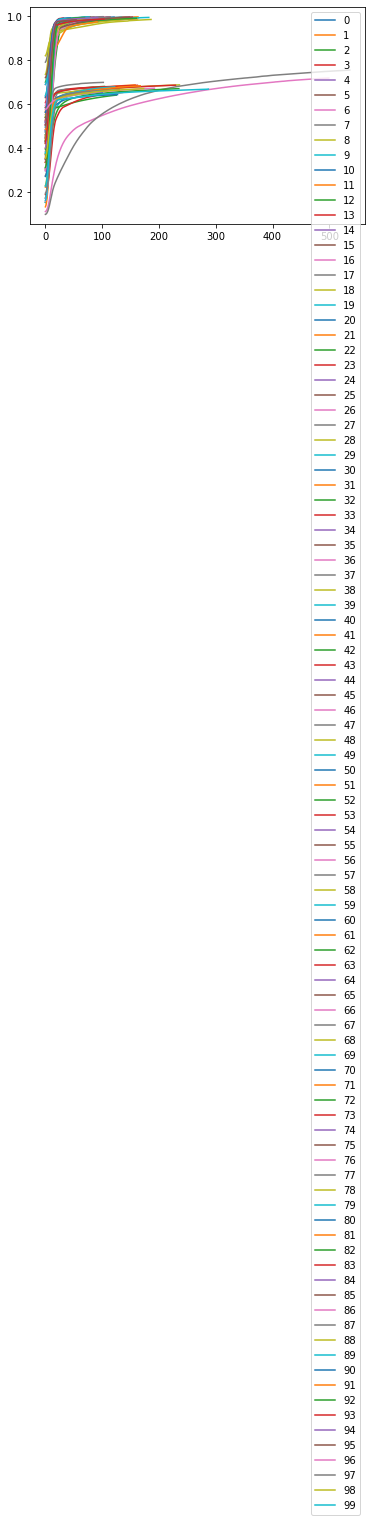

In [12]:
record_c = []
record_f = {}
n_trails = 100
start_time = time.time()
for i in range(n_trails): # apply GRAPE with random initial multiple times
    print(i)
    fidelity,c = GRAPE(T,L,omega,H,GA,GB)
    record_c.append(c)
    record_f.update({i:fidelity})
    with open("2023_GRAPE_sum.bin", "wb") as f:
        pickle.dump([record_c, record_f], f)
    plt.plot(fidelity)
    
end_time = time.time()
plt.legend([str(i) for i in range(n_trails)])
plt.show()
print(end_time-start_time)

In [13]:
print(end_time)

1698028166.436561


25
[44, 164, 101, 115, 88, 149, 99, 28, 79, 25, 52, 101, 81, 103, 110, 77, 95, 115, 163, 109, 120, 80, 26, 78, 66, 23, 26, 22, 146, 92, 183, 122, 97, 125, 111, 89, 109, 66, 73, 65, 33, 113, 86, 156, 90, 89, 165, 127, 64, 101, 25, 110, 162, 135, 45, 141, 161, 32, 113, 113, 114, 187, 92, 42, 56, 78, 154, 32, 82, 78, 81, 70, 104, 93, 55]
93.28
41.384879686507084
[167, 121, 79, 159, 237, 500, 126, 137, 537, 236, 230, 26, 128, 105, 163, 42, 85, 123, 101, 103, 168, 193, 131, 174, 288]
174.36
117.85274880120531


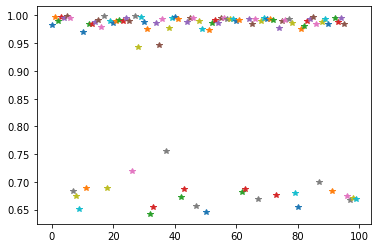

In [20]:
with open("2023_GRAPE_sum.bin", "rb") as f:
    rec_c, rec_f= pickle.load(f)

lists = sorted(rec_f.items())
x, y = zip(*lists) 
count = 0
conv_u = []
conv_l = []

for i in range(n_trails):
    p_y = y[i]
    if p_y[-1]<0.8:
        count += 1
        conv_l.append(len(p_y))
    else:
        conv_u.append(len(p_y))
    plt.plot(x[i],p_y[-1],'*')
    
print(count)
print(conv_u)
print(np.mean(conv_u))
print(np.std(conv_u))
print(conv_l)
print(np.mean(conv_l))
print(np.std(conv_l))